In [20]:
!pip install shap

  Using cached shap-0.48.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.61.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.44.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.8 kB)
Using cached shap-0.48.0-cp313-cp313-macosx_11_0_arm64.whl (546 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.61.2-cp313-cp313-macosx_11_0_arm64.whl (2.8 MB)
Using cached llvmlite-0.44.0-cp313-cp313-macosx_11_0_arm64.whl (26.2 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]4/6 [numba]te]


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import shap
import joblib

In [22]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race',
    'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
    'native-country', 'salary'
]
df = pd.read_csv("adult.csv", names=columns, skipinitialspace=True, na_values="?")
df.dropna(inplace=True)


In [23]:
cat_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc

In [24]:
X = df.drop('salary', axis=1)
y = df['salary']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [26]:
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
]

In [27]:
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    cv=5
)
stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)


In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8649096635173213
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4503
           1       0.79      0.64      0.71      1530

    accuracy                           0.86      6033
   macro avg       0.84      0.79      0.81      6033
weighted avg       0.86      0.86      0.86      6033



PermutationExplainer explainer: 101it [00:31,  2.33it/s]                        
/var/folders/80/8r3nx78d43dddm13mw27gvv80000gn/T/ipykernel_23106/713681850.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test[:100], feature_names=X.columns)


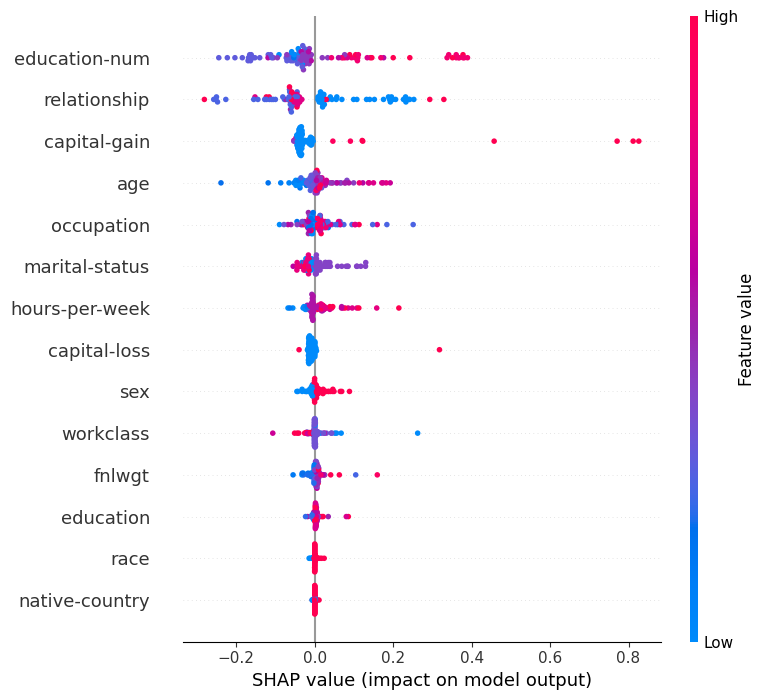

In [29]:
explainer = shap.Explainer(stack_model.predict, X_test)
shap_values = explainer(X_test[:100])
shap.summary_plot(shap_values, features=X_test[:100], feature_names=X.columns)


In [30]:
joblib.dump(stack_model, "salary_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoders, "encoders.pkl")


['encoders.pkl']